In [1]:
import tensorflow as tf
import os
import random
import shutil
from keras.preprocessing.image import ImageDataGenerator

## Pre-Processing

In [2]:
def get_data():
    !wget 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
    try:
        from zipfile import ZipFile
    except ImportError:
        return
    
    fname = "kagglecatsanddogs_5340.zip"

    with ZipFile(fname,'r') as zip:
        zip.extractall()
    
    #corrupt images
    !rm PetImages/Cat/666.jpg
    !rm PetImages/Dog/11702.jpg
    
    print('Done Extracting data')


In [3]:
get_data()

--2022-11-11 21:42:54--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.55.181.109, 2600:1413:b000:793::317f, 2600:1413:b000:78a::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.55.181.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   230MB/s    in 3.4s    

2022-11-11 21:42:58 (231 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]

Done Extracting data


In [4]:
path_cat='/content/PetImages/Cat/'
path_dog='/content/PetImages/Dog'

#randomly selecting 2000 cat images and dog images
img_list_cat = random.sample(os.listdir('/content/PetImages/Cat/'), k=2000)
img_list_dog = random.sample(os.listdir('/content/PetImages/Dog'), k=2000)

# deleting images so only 2000 randomly selected images remain
[os.remove(os.path.join(path_cat, file)) for file in os.listdir('/content/PetImages/Cat/') if file not in img_list_cat]
[os.remove(os.path.join(path_dog, file)) for file in os.listdir('/content/PetImages/Dog/') if file not in img_list_dog]
print('Done')

Done


In [5]:
print(len(os.listdir(path_cat)))
print(len(os.listdir(path_dog)))

2000
2000


### Making test, train and val folders for generator

In [6]:
def train_test_val():
    path='Data/'

    #if files already exist, remove all the data in them
    try:
        os.mkdir('Data/')
    except FileExistsError:
        !rm 'Data/' -r
    
    !mkdir 'Data/'
    !mkdir 'Data/Train/'
    !mkdir 'Data/Train/Cat/'
    !mkdir 'Data/Train/Dog/'
    !mkdir 'Data/Test/'
    !mkdir 'Data/Test/Cat/'
    !mkdir 'Data/Test/Dog/'
    !mkdir 'Data/Val/'
    !mkdir 'Data/Val/Cat/'
    !mkdir 'Data/Val/Dog/'


    # Now need to move files around
    # We'll use a 70 15 15 split, 70% training data, 15% validation data, 15% testing data
    
    # Cats
    src_cat = '/content/PetImages/Cat/'
    dst_train_cat = '/content/Data/Train/Cat/'
    dst_test_cat = '/content/Data/Test/Cat/'
    dst_val_cat = '/content/Data/Val/Cat/'

    train_cat_data =os.listdir('/content/PetImages/Cat/')[0:1400] #70%
    test_cat_data = os.listdir('/content/PetImages/Cat/')[1401:1700] #~15%
    val_cat_data = os.listdir('/content/PetImages/Cat/')[1701:] #~15%
    
    # Dogs
    src_dog = '/content/PetImages/Dog/'
    dst_train_dog = '/content/Data/Train/Dog/'
    dst_test_dog = '/content/Data/Test/Dog/'
    dst_val_dog = '/content/Data/Val/Dog/'

    train_dog_data =os.listdir('/content/PetImages/Dog/')[0:1400] #70%
    test_dog_data = os.listdir('/content/PetImages/Dog/')[1401:1700] #15%
    val_dog_data = os.listdir('/content/PetImages/Dog/')[1701:] #15%

    # using shutil.move()
    print('Moving dogs...')
    [shutil.move(src=os.path.join(src_dog, file), dst=os.path.join(dst_train_dog, file)) for file in train_dog_data]
    [shutil.move(src=os.path.join(src_dog, file), dst=os.path.join(dst_test_dog, file)) for file in test_dog_data]
    [shutil.move(src=os.path.join(src_dog, file), dst=os.path.join(dst_val_dog, file)) for file in val_dog_data]
    print('Done moving dogs')

    print('Moving cats...')
    [shutil.move(src=os.path.join(src_cat, file), dst=os.path.join(dst_train_cat, file)) for file in train_cat_data]
    [shutil.move(src=os.path.join(src_cat, file), dst=os.path.join(dst_test_cat, file)) for file in test_cat_data]
    [shutil.move(src=os.path.join(src_cat, file), dst=os.path.join(dst_val_cat, file)) for file in val_cat_data]
    print('Done moving cats')

    print(f'Size of train cat dir: {len(os.listdir(dst_train_cat))}')
    print(f'Size of test cat dir: {len(os.listdir(dst_test_cat))}')
    print(f'Size of val cat dir: {len(os.listdir(dst_val_cat))}')
    print(f'Size of train dog dir: {len(os.listdir(dst_train_dog))}')
    print(f'Size of test dog dir: {len(os.listdir(dst_test_dog))}')
    print(f'Size of val dog dir: {len(os.listdir(dst_val_dog))}')


In [7]:
train_test_val()

mkdir: cannot create directory ‘Data/’: File exists
Moving dogs...
Done moving dogs
Moving cats...
Done moving cats
Size of train cat dir: 1400
Size of test cat dir: 299
Size of val cat dir: 299
Size of train dog dir: 1400
Size of test dog dir: 299
Size of val dog dir: 299


#### Instantiating generators

In [8]:
train_dir = '/content/Data/Train/'
test_dir = '/content/Data/Test/'
val_dir = '/content/Data/Val/'

img_dim = 150
batch_size = 32
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')


test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') 


val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

Found 2800 images belonging to 2 classes.
Found 598 images belonging to 2 classes.
Found 598 images belonging to 2 classes.


## Model Development

In [9]:
#Imports
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt

In [ ]:
def model_init():
    model = models.Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_dim, img_dim, 3)))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='relu'))

    model.add(layers.Dense(units=1, activation='sigmoid'))

    return model



In [ ]:
model = model_init()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                      

### Training model

In [ ]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=round(train_generator.samples/train_generator.batch_size),
    epochs=10,
    validation_data=val_generator,
    validation_steps=round(val_generator.samples/val_generator.batch_size),
    # verbose=0
    # workers = 10,use_multiprocessing=True)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
88/88 [==============================] - 28s 314ms/step - loss: 0.8327 - acc: 0.5071 - val_loss: 0.6844 - val_acc: 0.5468
Epoch 2/10
88/88 [==============================] - 26s 299ms/step - loss: 0.6911 - acc: 0.5264 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 3/10
88/88 [==============================] - 26s 299ms/step - loss: 0.6954 - acc: 0.4886 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/10
88/88 [==============================] - 27s 303ms/step - loss: 0.6933 - acc: 0.4989 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/10
88/88 [==============================] - 27s 301ms/step - loss: 0.6942 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/10
88/88 [==============================] - 27s 303ms/step - loss: 0.6941 - acc: 0.4939 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/10
88/88 [==============================] - 27s 313ms/step - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/10
88/88 [==============================] - 27s 302ms/step - 

Let's visualize the results:

In [ ]:
# plotting function:
def generate_plots(history):
    #accuracies
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    #loss curves
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

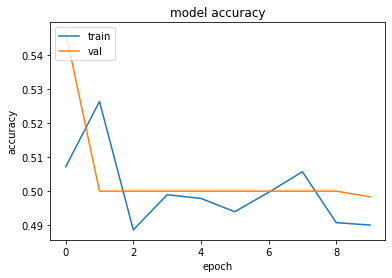

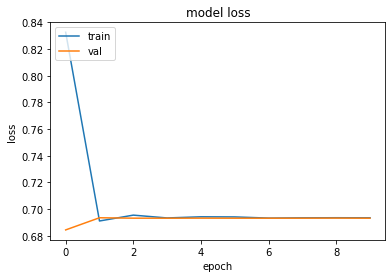

In [ ]:
generate_plots(history=history)

It's showing signs of over-fitting right away

In [ ]:
results = model.evaluate(test_generator, steps=round(test_generator.samples/test_generator.batch_size))
print(f'Model test accuracy: {results[1]}')
print(f'Model test loss: {results[0]}')

19/19 [==============================] - 2s 91ms/step - loss: 0.6943 - acc: 0.5033
Model test accuracy: 0.5033444762229919
Model test loss: 0.6943406462669373


### Visualizing Activations

In [ ]:
# from keras.preprocessing import image
import numpy as np

In [ ]:
img = tf.keras.preprocessing.image.load_img('/content/Data/Val/Cat/10048.jpg', target_size=(img_dim, img_dim))

In [ ]:
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
# expand dims
img_tensor = np.expand_dims(img_tensor, axis=0)
#normalize
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


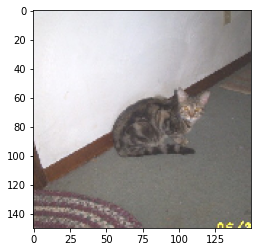

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

1/1 [==============================] - 0s 63ms/step
first layer activation shape: (1, 148, 148, 32)


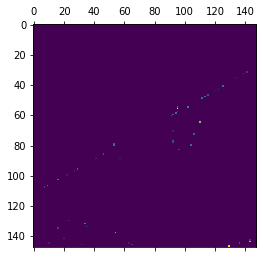

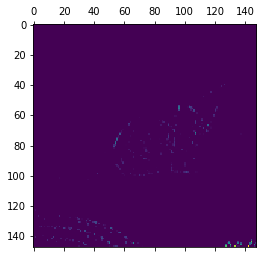

In [ ]:
# select outputs of the top 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]]

#create new model
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

#run the model on the image
activations = activation_model.predict(img_tensor)

#examine the returned activations
first_layer_activation = activations[0]
print(f'first layer activation shape: {first_layer_activation.shape}')

#let's visualize the 3rd and 7th activation layers
plt.matshow(first_layer_activation[0,:,:,3], cmap='viridis')
plt.matshow(first_layer_activation[0,:,:,7], cmap='viridis')




Conclusion: In the third layer it seems to be trying to detect stuff like walls and straight lines. In the 7th layer though we see a majority of the important stuff being detected like the roundness of the cat around its rear and also some activation around its eyes and ears. 

### Visualizing filters that maximize response

In [ ]:
from keras import backend as K

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 72, 72, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                     

In [ ]:
layer_output = model.get_layer('conv2d_47').output
filter_index = 0
loss = K.mean(layer_output[:,:,:,filter_index])

In [ ]:
# Compute loss wrt grads
grads=K.gradients(loss, model.input)[0]

#normalize grads
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

RuntimeError: ignored

Well I ran into an issue here so I am unable to move forward with the task of visualizing trained filters to see what will maximize their response. But here is how I WOULD continue if I didn't get this error:
1. Get the gradients, compute the loss (from above) 
2. Instantiate a Keras function w/ inputs (model.input) and outputs (loss, grads)
3. Run the computation graph from inputs to outputs with an input image of zeros
4. Maximize the response measure wrt input using gradient ascent. So we start with a gray image with some noise 
Can instantiate the gray image as such: np.random.random((1, img_dim, img_dim, 3)) * 20 + 128)

have a step size

and then run gradient ascent for 50 - 100 iterations where-by I evaluate the sub-graph loss and gradients for the current input and update the image using the gradient and step size. The image would get updated by adding the gradient value and multiplying by the step. 

5. And then you can deprocess the image by scaling to 0 mean, unit std dev., clipping to 0,1 and converting vals between 0,255
6. lastly just plot it to visualize using plt.imshow()

I hope this explanation was enough to atleast get me partial points for this portion since I know how to do it just unfortunately couldn't get it to work and I need to keep moving in order to submit on time.

The interpretation of the image we get i
s as such:
The image shows what maximizes the output for a specific given layer (i.e. what excites the neurons the most) it may be something as benign as a bunch of random lines or something interesting like the shape of a cats ears.

### Replacing convolution layers w/ pretrained conv base of VGG16

In [10]:
def model_vgg():
    img_dim=150
    try:
        from keras.applications import VGG16
    except ImportError:
        print('Install Keras first')
        return

    conv_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(img_dim,img_dim,3)
    )
    print(f'Convolution Base from VGG16 summary: {conv_base.summary()}')

    # setting pretrained model to be frozen
    conv_base.trainable = False

    model2 = models.Sequential()
    model2.add(conv_base)
    model2.add(layers.Flatten())
    model2.add(layers.Dense(256, activation='relu'))
    model2.add(layers.Dense(1, activation='sigmoid'))
    
    print(f'Model with conv base & binary classifier at the end summary: {model2.summary()}')

    return model2

In [11]:
model_vggbase = model_vgg()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [12]:
# compile the model
model_vggbase.compile(loss="binary_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=0.0008), 
              metrics=["acc"])

history2 = model_vggbase.fit_generator(
                             generator=train_generator,
                             steps_per_epoch=round(train_generator.samples/train_generator.batch_size),
                             epochs=10,
                             validation_data=val_generator,
                             validation_steps=round(val_generator.samples/val_generator.batch_size)
                            )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10
88/88 [==============================] - 25s 176ms/step - loss: 2.0600 - acc: 0.9086 - val_loss: 0.6171 - val_acc: 0.9331
Epoch 2/10
88/88 [==============================] - 18s 203ms/step - loss: 0.1230 - acc: 0.9725 - val_loss: 0.4007 - val_acc: 0.9398
Epoch 3/10
88/88 [==============================] - 16s 182ms/step - loss: 0.0265 - acc: 0.9914 - val_loss: 0.3529 - val_acc: 0.9465
Epoch 4/10
88/88 [==============================] - 12s 137ms/step - loss: 0.0059 - acc: 0.9979 - val_loss: 0.3666 - val_acc: 0.9548
Epoch 5/10
88/88 [==============================] - 12s 138ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.3998 - val_acc: 0.9482
Epoch 6/10
88/88 [==============================] - 13s 153ms/step - loss: 1.1827e-04 - acc: 1.0000 - val_loss: 0.3936 - val_acc: 0.9482
Epoch 7/10
88/88 [==============================] - 12s 136ms/step - loss: 4.5899e-05 - acc: 1.0000 - val_loss: 0.3957 - val_acc: 0.9482
Epoch 8/10
88/88 [==============================] - 12s 137ms

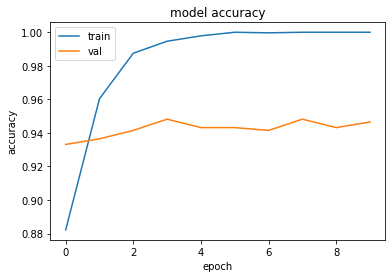

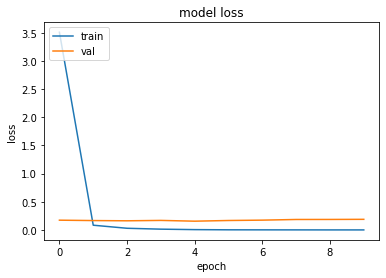

In [ ]:
generate_plots(history2)

In [13]:
results_3 = model_vggbase.evaluate(test_generator, steps=round(test_generator.samples/test_generator.batch_size))
print(f'Model vggbase test accuracy: {results_3[1]}')
print(f'Model vggbase test loss: {results_3[0]}')

19/19 [==============================] - 2s 115ms/step - loss: 0.2583 - acc: 0.9548
Model vggbase test accuracy: 0.9548494815826416
Model vggbase test loss: 0.2583298981189728


In [ ]:
model_vggbase.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Setting trainable to TRUE and fine-tuning

In [ ]:
model_vggbase.layers[0].trainable = True

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


88/88 [==============================] - 12s 136ms/step - loss: 1.4916e-04 - acc: 1.0000 - val_loss: 0.1904 - val_acc: 0.9448
Epoch 2/10
88/88 [==============================] - 12s 136ms/step - loss: 1.1799e-04 - acc: 1.0000 - val_loss: 0.1923 - val_acc: 0.9465
Epoch 3/10
88/88 [==============================] - 17s 198ms/step - loss: 9.8216e-05 - acc: 1.0000 - val_loss: 0.1926 - val_acc: 0.9482
Epoch 4/10
88/88 [==============================] - 14s 162ms/step - loss: 8.0993e-05 - acc: 1.0000 - val_loss: 0.1945 - val_acc: 0.9465
Epoch 5/10
88/88 [==============================] - 12s 138ms/step - loss: 6.9141e-05 - acc: 1.0000 - val_loss: 0.1957 - val_acc: 0.9465
Epoch 6/10
88/88 [==============================] - 13s 145ms/step - loss: 5.9446e-05 - acc: 1.0000 - val_loss: 0.1977 - val_acc: 0.9465
Epoch 7/10
88/88 [==============================] - 12s 138ms/step - loss: 5.2004e-05 - acc: 1.0000 - val_loss: 0.1984 - val_acc: 0.9465
Epoch 8/10
88/88 [==============================] - 

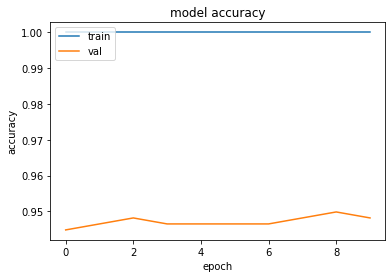

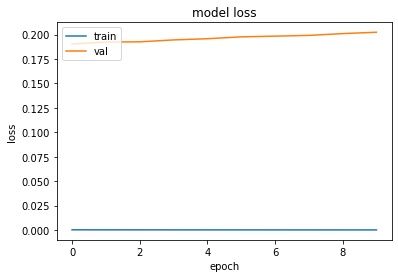

In [ ]:
# model3 = model_vgg_trainableTrue()

# compile the model
# model3.compile(loss="binary_crossentropy", 
#               optimizer=optimizers.Adam(learning_rate=0.0008), 
#               metrics=["acc"])

history3 = model_vggbase.fit_generator(
                             generator=train_generator,
                             steps_per_epoch=round(train_generator.samples/train_generator.batch_size),
                             epochs=10,
                             validation_data=val_generator,
                             validation_steps=round(val_generator.samples/val_generator.batch_size)
                            )

generate_plots(history3)

In [ ]:
results_4 = model_vggbase.evaluate(test_generator, steps=round(test_generator.samples/test_generator.batch_size))
print(f'Model vggbase test accuracy: {results_4[1]}')
print(f'Model vggbase test loss: {results_4[0]}')

17/19 [=========================>....] - ETA: 0s - loss: 0.3460 - acc: 0.9301

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

19/19 [==============================] - 2s 113ms/step - loss: 0.3183 - acc: 0.9331
Model vggbase test accuracy: 0.9331103563308716
Model vggbase test loss: 0.31833526492118835


In [14]:
model_vggbase.save('model_vggbase.h5')

### Comparing results
Normal model convnet: test accuracy = .676
                    test loss = .978

VGG16 (conv base trainable = false): test accuracy = .936
                                        test loss = .286

VGG16 (conv base trainable = true): test accuracy = .9331
                                    test loss = .318

#### Modifying data generators to perform data augmentation & re-training with frozen convolution base

In [ ]:
train_dir = '/content/Data/Train/'
test_dir = '/content/Data/Test/'
val_dir = '/content/Data/Val/'

img_dim = 150
batch_size = 32

datagen = ImageDataGenerator()

train_datagen = ImageDataGenerator(
    vertical_flip=True,
    rotation_range=15,
    fill_mode='nearest',
    height_shift_range=0.1,
    width_shift_range=0.1, 
    brightness_range=[0.1,0.5],
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    vertical_flip=True,
    rotation_range=20,
    fill_mode='nearest',
    height_shift_range=0.15,
    width_shift_range=0.05, 
    brightness_range=[0.05,0.1],
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')


test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')


val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

Found 2800 images belonging to 2 classes.
Found 598 images belonging to 2 classes.
Found 598 images belonging to 2 classes.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
88/88 [==============================] - 40s 348ms/step - loss: 0.9227 - acc: 0.8075 - val_loss: 0.4052 - val_acc: 0.8829
Epoch 2/10
88/88 [==============================] - 28s 321ms/step - loss: 0.2793 - acc: 0.8889 - val_loss: 0.3559 - val_acc: 0.8779
Epoch 3/10
88/88 [==============================] - 29s 333ms/step - loss: 0.2599 - acc: 0.8932 - val_loss: 0.3567 - val_acc: 0.8428
Epoch 4/10
88/88 [==============================] - 28s 323ms/step - loss: 0.2246 - acc: 0.9125 - val_loss: 0.3080 - val_acc: 0.8729
Epoch 5/10
88/88 [==============================] - 28s 321ms/step - loss: 0.2042 - acc: 0.9161 - val_loss: 0.3217 - val_acc: 0.8612
Epoch 6/10
88/88 [==============================] - 29s 324ms/step - loss: 0.2115 - acc: 0.9182 - val_loss: 0.3281 - val_acc: 0.8595
Epoch 7/10
88/88 [==============================] - 28s 323ms/step - loss: 0.1731 - acc: 0.9357 - val_loss: 0.2864 - val_acc: 0.8796
Epoch 8/10
88/88 [==============================] - 29s 334ms/step - 

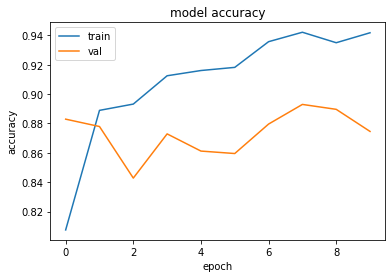

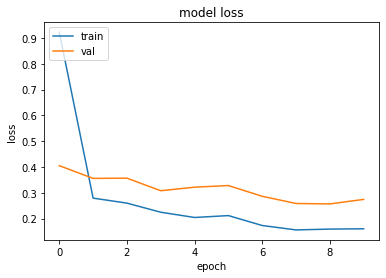

In [ ]:
# Re-train with convolution base
model_vggbase_2 = model_vgg()

# compile the model
model_vggbase_2.compile(loss="binary_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=0.0008), 
              metrics=["acc"])

history_dataaugmentation = model_vggbase_2.fit_generator(
                             generator=train_generator,
                             steps_per_epoch=round(train_generator.samples/train_generator.batch_size),
                             epochs=10,
                             validation_data=val_generator,
                             validation_steps=round(val_generator.samples/val_generator.batch_size)
                            )

generate_plots(history_dataaugmentation)


In [ ]:
results_4 = model_vggbase_2.evaluate(test_generator, steps=round(test_generator.samples/test_generator.batch_size))
print(f'Model vggbase test accuracy: {results_4[1]}')
print(f'Model vggbase test loss: {results_4[0]}')

19/19 [==============================] - 2s 108ms/step - loss: 0.6857 - acc: 0.9264
Model vggbase test accuracy: 0.9264214038848877
Model vggbase test loss: 0.6856550574302673


Results:
With data augmentation we don't really see that much of an improvement